In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("working_data.csv")

# Separate descriptors and target
player_descriptors = df.iloc[:, :3]
league = df['Lg']
cy_young_place = df['Cy_young']
X = df.iloc[:, 3:-2]

# Add league temporarily for sorting
X['Lg'] = league
y = cy_young_place

# Create separate datasets
x_al = X[X['Lg'] == 'AL'].drop(columns=['Lg'])
x_nl = X[X['Lg'] == 'NL'].drop(columns=['Lg'])

y_al = y[league == 'AL']
y_nl = y[league == 'NL']


In [4]:
# Read selected features (from forest importance)
with open('forest_importance_nl.json', 'r') as f:
    selected_features_nl_importance = json.load(f)

with open('forest_importance_al.json', 'r') as f:
    selected_features_al_importance = json.load(f)

# Read selected features (from Chi-squared)
with open('chi2_selected_features_nl.json', 'r') as f:
    selected_features_nl_chi2 = json.load(f)


with open('chi2_selected_features_al.json', 'r') as f:
    selected_features_al_chi2 = json.load(f)

# Print selected features
print("Selected Features for NL:", selected_features_nl_importance)
print("Selected Features for AL:", selected_features_al_importance)
print("Selected Features for NL:", selected_features_nl_chi2)
print("Selected Features for AL:", selected_features_al_chi2)

Selected Features for NL: ['WAR', 'SO', 'ERA+', 'FIP', 'WHIP', 'IP', 'ERA', 'W', 'BF', 'SO/BB']
Selected Features for AL: ['WAR', 'SO', 'IP', 'FIP', 'BF', 'ERA+', 'ERA', 'W', 'WHIP', 'GS']
Selected Features for NL: ['WAR', 'W', 'ERA', 'CG', 'SHO', 'IP', 'SO', 'BF', 'ERA+', 'SO/BB']
Selected Features for AL: ['WAR', 'W', 'CG', 'SHO', 'IP', 'SO', 'BK', 'BF', 'ERA+', 'SO/BB']


In [5]:
#Random Forest Importance
x_nl_importance = x_nl[selected_features_nl_importance]
x_al_importance = x_al[selected_features_al_importance]

# Chi-squared Features
x_nl_chi2 = x_nl[selected_features_nl_chi2]
x_al_chi2 = x_al[selected_features_al_chi2]


In [6]:
#forest feature trees
clf_nl_forest = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf_nl_forest.fit(x_nl_importance, y_nl)
clf_al_forest = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf_al_forest.fit(x_al_importance, y_al)

#chi2 feature trees
clf_nl_chi2 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf_nl_chi2.fit(x_nl_chi2, y_nl)
clf_al_chi2 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf_al_chi2.fit(x_al_chi2, y_al)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Plot the Trees


forest tree nl:



[Text(0.5, 0.875, 'x[0] <= 4.05\nentropy = 1.052\nsamples = 353\nvalue = [304.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 4.0, 2.0\n2.0, 4.0]'),
 Text(0.25, 0.625, 'x[1] <= 171.5\nentropy = 0.357\nsamples = 302\nvalue = [290, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[3] <= 3.005\nentropy = 0.036\nsamples = 262\nvalue = [261, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'),
 Text(0.0625, 0.125, 'entropy = 0.439\nsamples = 11\nvalue = [10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'),
 Text(0.1875, 0.125, 'entropy = 0.0\nsamples = 251\nvalue = [251, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.375, 0.375, 'x[7] <= 14.5\nentropy = 1.65\nsamples = 40\nvalue = [29, 0, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2]'),
 Text(0.3125, 0.125, 'entropy = 0.905\nsamples = 33\nvalue = [28, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2]'),
 Text(0.4375, 0.125, 'entropy = 2.522\nsamples = 7\nvalue = [1, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0]'),
 Text(0.75, 0.625, 'x[6] <= 2.465\nentropy = 3.155\nsamples = 51\nvalue = [1

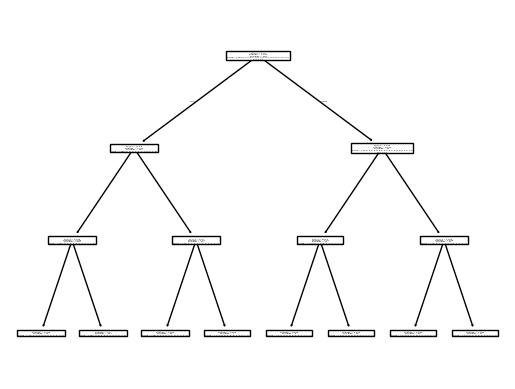

In [7]:
print("forest tree nl:\n")
plot_tree(clf_nl_forest)


forest tree al:



[Text(0.4230769230769231, 0.875, 'x[1] <= 179.5\nentropy = 0.935\nsamples = 365\nvalue = [321.0, 5.0, 5.0, 4.0, 5.0, 5.0, 6.0, 4.0, 3.0, 4.0\n2.0, 1.0]'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 3.75\nentropy = 0.184\nsamples = 304\nvalue = [298, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'entropy = 0.0\nsamples = 287\nvalue = [287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.23076923076923078, 0.375, 'x[8] <= 1.055\nentropy = 1.731\nsamples = 17\nvalue = [11, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.15384615384615385, 0.125, 'entropy = 1.5\nsamples = 4\nvalue = [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0]'),
 Text(0.3076923076923077, 0.125, 'entropy = 0.773\nsamples = 13\nvalue = [11, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 4.15\nentropy = 2.982\nsamples = 61\nvalue = [23, 5, 5, 3, 4, 5, 6, 3, 1, 4, 1, 1]'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.

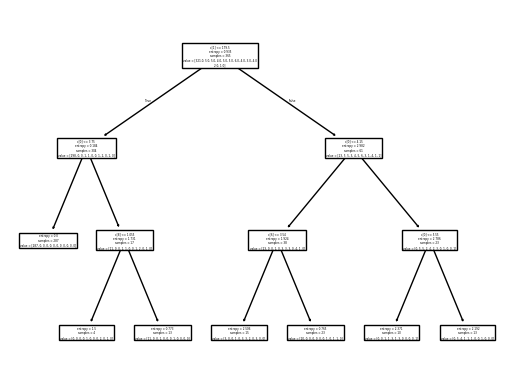

In [8]:
print("forest tree al:\n")
plot_tree(clf_al_forest)

chi2 tree nl:



[Text(0.5, 0.875, 'x[0] <= 4.05\nentropy = 1.052\nsamples = 353\nvalue = [304.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 4.0, 2.0\n2.0, 4.0]'),
 Text(0.25, 0.625, 'x[6] <= 171.5\nentropy = 0.357\nsamples = 302\nvalue = [290, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[3] <= 1.5\nentropy = 0.036\nsamples = 262\nvalue = [261, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 256\nvalue = [256, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.1875, 0.125, 'entropy = 0.65\nsamples = 6\nvalue = [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'),
 Text(0.375, 0.375, 'x[1] <= 14.5\nentropy = 1.65\nsamples = 40\nvalue = [29, 0, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2]'),
 Text(0.3125, 0.125, 'entropy = 0.905\nsamples = 33\nvalue = [28, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2]'),
 Text(0.4375, 0.125, 'entropy = 2.522\nsamples = 7\nvalue = [1, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0]'),
 Text(0.75, 0.625, 'x[2] <= 2.465\nentropy = 3.155\nsamples = 51\nvalue = [14.0, 

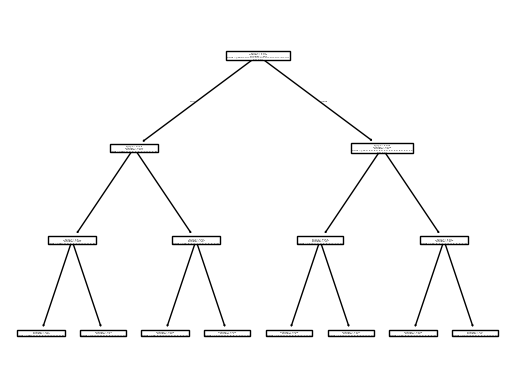

In [9]:
print("chi2 tree nl:\n")
plot_tree(clf_nl_chi2)

chi2 tree al:



[Text(0.4230769230769231, 0.875, 'x[5] <= 179.5\nentropy = 0.935\nsamples = 365\nvalue = [321.0, 5.0, 5.0, 4.0, 5.0, 5.0, 6.0, 4.0, 3.0, 4.0\n2.0, 1.0]'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 3.75\nentropy = 0.184\nsamples = 304\nvalue = [298, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'entropy = 0.0\nsamples = 287\nvalue = [287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.23076923076923078, 0.375, 'x[4] <= 156.0\nentropy = 1.731\nsamples = 17\nvalue = [11, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.15384615384615385, 0.125, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.3076923076923077, 0.125, 'entropy = 2.419\nsamples = 9\nvalue = [3, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 4.15\nentropy = 2.982\nsamples = 61\nvalue = [23, 5, 5, 3, 4, 5, 6, 3, 1, 4, 1, 1]'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.37

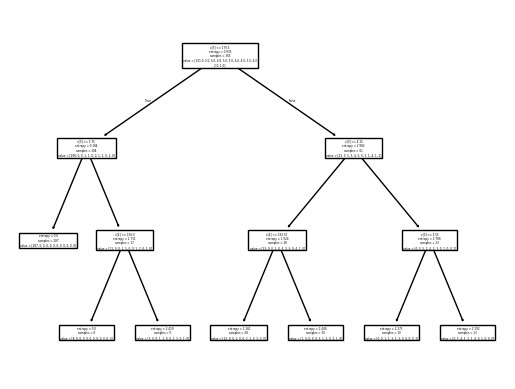

In [10]:
print("chi2 tree al:\n")
plot_tree(clf_al_chi2)